# **Tutorial** : What cartographic representation for a point data set ? 
## Overview of some existing techniques with the CartAGen tool
Press **`space bar`** to display the next slide.
_If this Notebook doesn't appear in slideshow mode, reload the page_

- 🙋 **For whom ?** : 
  - people who have spatial data to be enhanced by maps, but don't know which cartographic representation to choose.
  - expert cartographers wishing to discover the **possibilities of cartographic generalization** offered by the CartAGen tool
  - anyone wishing to find out about the various problems encountered when creating maps from point data (and how to get around these problems).

Press **`spacebar`** and **`scroll down`** to display the following message. _Reload the page if you can't scroll down._ 


- ❓ **What is CartAGen ?** :
    - an **open source Python library** made by **IGN** (i.e the french national mapping agency) researchers
    - a tool to carry out cartographic generalization processes and **automate** them
    - a **QGIS plugin** to use the Python library in a GIS environment  
    
Press **`space bar`** and **`scroll down`** to show next message 


- 📗 **How to use this Notebook ?** : 
    - a Notebook is a document that mixes **markdown cells** (i.e. cells with formatted text like this one) and **code cells**, which you can modify and execute at will
    - it comes with a **sample data set** on which you can **test** the various features of the CartAGen python library
    - you can import your **own data** and run the code cells of this Notebook, or use the CartAGen tool in **another environment** (QGIS or python script)

Press **`right arrow`** to show next slide and start part 0, or press **`space bar`** to show sub-slide and see useful links

   
- 🔗 **Useful links** : 
    - [Library repository](https://github.com/LostInZoom/cartagen4py?tab=readme-ov-file) 
    - [QGIS Plugin repository](https://github.com/LostInZoom/cartagen-qgis)
    - [CartAGen documentation](https://cartagen4py.readthedocs.io/en/latest/index.html)

_by Paul Bourcier, 2024 - EUPL 1.2_

Press **`space bar`** to show next slide, press **`shift + space bar`** to go backward\
**`Click`** question mark icon to show other shortcuts

## ⚙️ **Part 0 :** Preparing the working environment

Press **`space bar`** to show code cell, then press **`shift + enter`** to execute it\
**`*`** symbol means code output is loading

In [1]:
# Importing libraries

import cartagen as cg # the main library, containing cartographic generalization algorithms

#geographic data manipulation 
import geopandas as gp # used to import and manipulate geographic data
from shapely.geometry import Polygon, MultiPolygon, Point # Create and manipulate geometries
from shapely.ops import linemerge, transform
from time import sleep # Creating loading bar

#displaying the data
from matplotlib import pyplot as plt # for ploting results, especially maps
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar # adding scalebar to the maps
import matplotlib.colors as matcol # generating color palettes
from matplotlib.path import Path  # Plot generation
from matplotlib.patches import PathPatch # Plot generation
from mpl_toolkits.axisartist.axislines import Subplot # Plot generation
import matplotlib.colors as mcolors #generating colors 
import matplotlib.cm as cm #used to display colorbar
import contextily as ctx # Adding basemaps

#creating interactive outputs
import ipywidgets # creation of interactive plots
import pydeck as pdk #deck.gl in Python for interactive maps
import json #manipulating dictionnaries
import progressbar
import ipyleaflet #creates interactive maps

# other data manipulation
import pandas as pd # used to concatenate datas
import numpy as np # Using mathematical operations in Python
from sklearn import cluster #clustering methods

import random #generating random numbers
import warnings # Remove warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*GeoDataFrame you are attempting to plot is empty.*") # Remove user warning 
warnings.filterwarnings("ignore", category=UserWarning, message=".*CRS not set for some of the concatenation inputs.*.")

## ❌ **Part 1 :** Common issues with point data representation

Nowadays, more and more spatial data shared by data producers takes the form of point data, i.e. data associated with a pair of x/y coordinates, enabling it to be integrated into maps. These point data concern a wide variety of themes: environment, population, urban planning, mobility, etc. 

Let's take a look at the challenges involved in mapping this type of data.

### **1.1/** Why displaying a raw dataset can lead to limitations?

When creating maps with the aim of showing the spatial distribution of a phenomenon, displaying each point in our dataset can prove problematic. Let's take the example of restaurants selling crepes in Brittany, France:

**1.1.1/** Displaying maps of creperies in Brittany

💬 This Notebook is meant to be interactive (beyond code modifications) : after **running** a code cell, you will often be able to **change** algorithm parameters or figure settings, thanks to **buttons**. Let's try changing the figure size thanks to a slider button.

In [2]:
#Displaying maps of crepe restaurants in Brittany
brittany = gp.read_file('data/puntos/brittany.geojson')
crepes = gp.read_file('data/puntos/crepes.geojson')
widgets = [
    '', progressbar.Percentage(), ' ',  
    progressbar.Bar(marker='🟩', left='', right='                                                  ', width = 1) 
]

def plt_bre_1(figure_size):
    
    with progressbar.ProgressBar(max_value=2,widgets=widgets) as bar:
        ax = brittany.plot(facecolor = 'None', edgecolor = "grey", linewidth = 0.5, figsize = (figure_size,figure_size))
        bar.update(1)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        scalebar = AnchoredSizeBar(ax.transData,
                                10000,  
                                '10 km',  
                                'lower left',  
                                pad=0.5,
                                color='black',
                                frameon=True,
                                size_vertical=1)
        ax.add_artist(scalebar)

        crepes.plot(ax=ax)    
        bar.update(2)
    
ipywidgets.interact(plt_bre_1, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 16,step = 1,continuous_update=False))

interactive(children=(IntSlider(value=12, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.plt_bre_1(figure_size)>

💬 This map shows all the creperies in Brittany that are represented in the [OSM](https://www.openstreetmap.org/#map=14/48.81620/-1.17910) database. As some points overlap, it is difficult to read the spatial distribution of these restaurants. Although we understand that there are more restaurants in the main cities and on certain parts of the coast, we can't really say whether there are more restaurants in Rennes or Brest, for example. 

💬 Let's try to lower the opacity of the points, so we can see more easily when several points are overlaping 

**1.1.2/** Displaying creperies with opacity

In [3]:
#Trying to lower the opacity to see if spatial distribution are more readable

def plt_bre_1(figure_size, opacity):
    with progressbar.ProgressBar(max_value=2,widgets=widgets) as bar:
        ax = brittany.plot(facecolor = 'None', edgecolor = "grey", linewidth = 0.5, figsize = (figure_size,figure_size))
        bar.update(1)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

        scalebar = AnchoredSizeBar(ax.transData,
                                10000,  
                                '10 km',  
                                'lower left',  
                                pad=0.5,
                                color='black',
                                frameon=True,
                                size_vertical=1)
        ax.add_artist(scalebar)

        crepes.plot(ax=ax, alpha = opacity)
        bar.update(2)
ipywidgets.interact(plt_bre_1, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 16,step = 1,continuous_update=False),
                               opacity = ipywidgets.FloatSlider(value =0.7, min = 0, max = 1,step = 0.01,continuous_update=False))



interactive(children=(IntSlider(value=12, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.plt_bre_1(figure_size, opacity)>

Thanks to this technique, the spatial distribution becomes clearer. But it's still not enough to determine in which city there are the most creperies! We'll look at some techniques for improving map legibility with regard to the spatial distribution of these restaurants in part 2... 

### **1.2/** Point data sets in multi-scale maps : the persistant problem of scale

Nowadays, geographical data is often enhanced through interactive maps, i.e. maps on which the user can modify the view by moving it, or zooming. As far as point data is concerned, it's true that this medium offers the possibility of seeing precisely where points are located in a given area. However, the display of raw data still generates problems of map legibility at certain scales.

Let's take the example of parking meters in Paris :

**1.2.1/** Interactive map of parking meters in Paris

💬 Once the interactive map is loaded, you can navigate through it just like in other website !

In [4]:
horo = gp.read_file('data/puntos/horodateurs-mobiliers.geojson')

for i in range(len(horo)):
    horo.loc[i,'lon'] = json.loads(horo.loc[i,'geo_point_2d'])['lon']
    horo.loc[i,'lat'] = json.loads(horo.loc[i,'geo_point_2d'])['lat']

mean_latitude = horo.lat.mean()
mean_longitude = horo.lon.mean()
df = horo.drop(columns='geometry')

layer = pdk.Layer(
    "ScatterplotLayer",
    df,
    opacity=0.8,
    stroked=True,
    filled=True,
    radius_scale=6,
    radius_min_pixels=5,
    radius_max_pixels=100,
    line_width_min_pixels=0,
    get_position=["lon", "lat"],
    pickable=True,
)

view_state = pdk.ViewState(longitude=mean_longitude, latitude=mean_latitude, zoom=15, bearing=0, pitch=0)

r = pdk.Deck(layers=[layer],initial_view_state=view_state, map_provider="carto",  map_style="light_no_labels", tooltip={"text": "{numhoro}"})

r.to_html('ScatterplotLayer.html')

This example highlights a fact: when the zoom level is high, displaying every point of our dataset is a good idea, as we can easily understand where each parking meter is located (which can be useful for finding one in a real-life context). 

However, when the zoom level is low (for example, when it's possible to see Paris as a whole), the map is saturated with information, as the raw representation of points is not optimized in this case.

In fact, the problem with displaying all points at low zoom levels is not only that the map is saturated with points, but also that the map reader's needs are probably not the same.

Indeed, when looking at the whole of Paris, the map reader's need is probably not to find the parking meters next to him, but more likely to understand how this equipment is distributed across the city (without understanding the precise location of each of them).

To conclude this section, interactive maps do not solve the problem of cartographic representation of point data. In other words, it is always necessary to transform them at certain scales, in order to make the map more readable. 

These transformations are known as map generalization. CartAGen is a tool for carrying out these operations.

## 🛠 **Part 2 :** Exploring cartographic generalization techniques with CartAGen
As we've seen, it's mostly scale that determines the choice of cartographic representation. Let's explore generalization techniques in terms of scale.

### **2.1/** Point displacement techniques
At large scales (i.e. small areas, high zoom levels...), we generally want to keep every point in our representation, in order to be as close as possible to reality. When points start to overlap, point displacement algorithms can be useful, as they make the map more legible while maintaining the number of points on the map.

**2.1.1/** Display the points to displace

100% 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩                                                  


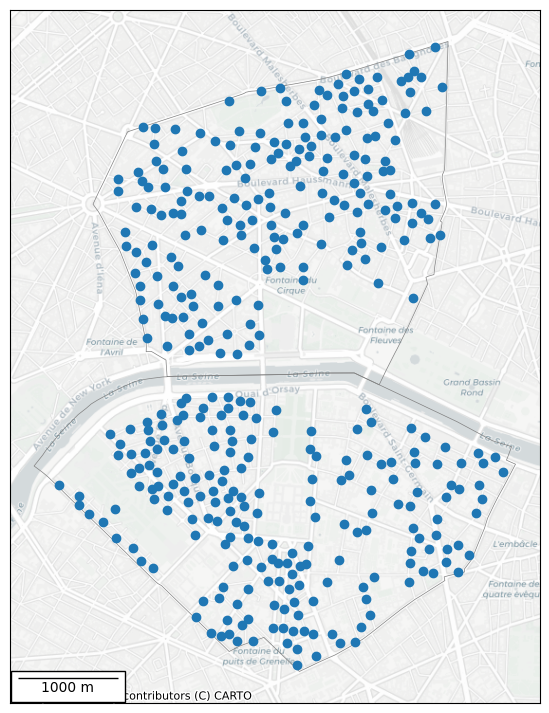

In [5]:
# Display points to displace
admin = gp.read_file('data/puntos/arr_paris.geojson')
admin.to_crs(crs="EPSG:3857",inplace=True)
horo.to_crs(crs="EPSG:3857",inplace=True)
horo_ok = gp.clip(horo, admin.loc[14:15])

with progressbar.ProgressBar(max_value=2,widgets=widgets) as bar:
    ax = admin.loc[14:15].plot(facecolor = 'None', edgecolor = "grey", linewidth = 0.5, figsize = (9,9))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    scalebar = AnchoredSizeBar(ax.transData,
                            1000,  
                            '1000 m',  
                            'lower left',  
                            pad=0.5,
                            color='black',
                            frameon=True,
                            size_vertical=1)
    ax.add_artist(scalebar)

    horo_ok.plot(ax=ax)
    bar.update(1)
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
    bar.update(2)

Yet, there is no algorithm dedicated to point displacement in CartAGen. Nonetheless, it is possible to use the random_displacement algorithm by transforming our points into polygons before : 

**2.1.2/** Converting points to polygons by creating buffers

In [6]:
# Converting points to polygons by creating buffers
horo_poly = horo_ok.copy()

with progressbar.ProgressBar(max_value=len(horo_poly),widgets=widgets) as bar:
    count = 0
    for index, pt in horo_poly.iterrows():
        horo_poly.loc[index,'geometry'] = horo_poly.loc[index,'geometry'].buffer(42)
        count += 1
        bar.update(count)
if horo_poly.geometry.geom_type.unique()[0] == 'Polygon':
    print("✅ successful transformation")
else:
    print("❌ transformation failed")

100% 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩                                                  


✅ successful transformation


**2.1.3/** Displacing points using the random_displacement algorithm

💬 Here, the “max trials” parameter is set to one, meaning that each entity that overlaps (or is too close) to another is moved once. 

If this parameter is set to two, the algorithm will perform the move twice (most likely in two different directions since it chooses randomly) and keep the situation with the fewest overlaps. 

A high value for this parameter will considerably lengthen calculation time (up to several minutes).

In [7]:
# Displacing point buffers
widgets1 = [
    '', progressbar.Percentage(), ' ',  
    progressbar.Bar(marker='🟩', left='', right='                        '), ' (', progressbar.ETA(), ') ' 
]
def disp_pts(polygon_distance, max_trials, max_displacement):
    global horo_poly
    with progressbar.ProgressBar(max_value=4,widgets=widgets1) as bar:
        bar.update(1)
        horo_poly = cg.random_displacement(horo_poly, polygon_distance=polygon_distance, max_trials=max_trials, max_displacement=max_displacement)
        bar.update(2)

        fig, axs = plt.subplots(1, 2, figsize = (14,14))

        axs[0].set_title('Before', pad=10, family='sans-serif')
        axs[0].scatter(np.asarray(horo_ok.geometry.get_coordinates())[:,:1], np.asarray(horo_ok.geometry.get_coordinates())[:,-1])
        bar.update(3)
        axs[0].set_xlim(left=254968, right=259800)
        axs[0].set_ylim(bottom=6248519, top=6255324)
        axs[0].set_aspect('equal')
        ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)

        axs[1].set_title('After', pad=10, family='sans-serif')
        axs[1].scatter(np.asarray(horo_poly.geometry.centroid.get_coordinates())[:,:1], np.asarray(horo_poly.geometry.centroid.get_coordinates())[:,-1])
        bar.update(4)
        axs[1].set_xlim(left=254968, right=259800)
        axs[1].set_ylim(bottom=6248519, top=6255324)
        axs[1].set_aspect('equal')
        ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
        fig.axes[1].get_xaxis().set_visible(False)
        fig.axes[1].get_yaxis().set_visible(False)
   

ipywidgets.interact(disp_pts, polygon_distance = ipywidgets.BoundedIntText(value=10, min=0, max=200, step=1,description='polygon distance',style={'description_width': 'initial'}),
                              max_trials = ipywidgets.BoundedIntText(value=1, min=0, max=200, step=1,description='max trials'),
                              max_displacement = ipywidgets.BoundedIntText(value=10, min=0, max=200, step=1,description='max displacement', style={'description_width': 'initial'}))

interactive(children=(BoundedIntText(value=10, description='polygon distance', max=200, style=DescriptionStyle…

<function __main__.disp_pts(polygon_distance, max_trials, max_displacement)>

A low “max_trials” parameter reduces calculation time, but the displacement obtained is often unsatisfactory. A “max_trials” value of 25 is better in our case (but the calculation time is long).

**2.1.3'/** Code details on random_displacement algorithm

<Axes: >

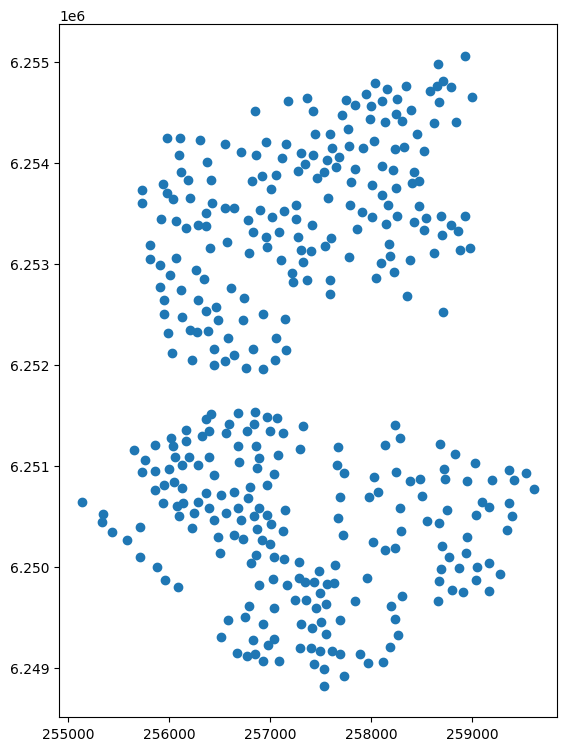

In [8]:
pm_polygons = horo_ok.copy() # copying the points to displace
pm_polygons.geometry = pm_polygons.geometry.buffer(42) #changing point geometry to polygon geometry with 42 meters buffer 

pm_polygons = cg.random_displacement(pm_polygons, polygon_distance=20,
                                                  max_trials=1, 
                                                  max_displacement=10)
                                     #displacing polygons /!\ can be long if max_trials is high

pm_polygons.geometry = pm_polygons.geometry.centroid 
pm_polygons.plot(figsize=(9,9)) #after displacement
horo_ok.plot(figsize=(9,9)) #before displacement

### **2.2/** Point reduction techniques
As the scale decreases, more and more points overlap, making it harder to perform displacement. At this point, having all the points on the map becomes less important: the map provides a global view of the spatial distribution of the data. Point reduction algorithms enable these transformations.

**2.2.1/** Using reduce_kmeans algorithm

In [9]:
# Reduce_points_kmeans algorithm
horo_ok = gp.clip(horo, admin.loc[13:16])

def kmean(figure_size, shrink_ratio):
    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))
    with progressbar.ProgressBar(max_value=5,widgets=widgets) as bar:
        horo_red = cg.reduce_kmeans(horo_ok,ratio=shrink_ratio,mode='simplification')
        bar.update(1)
        axs[0].set_title('Before', pad=10, family='sans-serif')
        axs[0].scatter(x=np.asarray(horo_ok.geometry.get_coordinates())[:,:1], y= np.asarray(horo_ok.geometry.get_coordinates())[:,-1])
        bar.update(2)
        ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
        bar.update(3)
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        axs[0].set_aspect('equal')
        
        axs[1].set_title('After', pad=10, family='sans-serif')
           
        axs[1].scatter(np.asarray(horo_red.geometry.x), np.asarray(horo_red.geometry.y))
        bar.update(4)
        ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
        bar.update(5)
        fig.axes[1].get_xaxis().set_visible(False)
        fig.axes[1].get_yaxis().set_visible(False)
        axs[1].set_aspect('equal')
        
ipywidgets.interact(kmean, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                           shrink_ratio = ipywidgets.FloatSlider(value =0.7, min = 0, max = 1,step = 0.01,continuous_update=False))

interactive(children=(IntSlider(value=16, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.kmean(figure_size, shrink_ratio)>

The kmeans point reduction algorithm tends to even out the spatial distribution of the point data set by deleting more points in areas of higher point density. This can be problematic, as the map representation may not reflect the actual spatial distribution. Here's another algorithm for reducing the number of points: 

**2.2.1'/** Code details on reduce_kmeans algorithm

In [10]:
horo_red = cg.reduce_kmeans(horo_ok,ratio=0.7,mode='simplification')

horo_red.plot(figsize=(9,9))

<Axes: >

**2.2.2/** Using reduce_quadtree algorithm

In [11]:
# reduce_points_quadtree algorithm (simplification mode)
horo_ok = gp.clip(horo, admin.loc[13:16])

def qtree_simp(figure_size, depth):
    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

    # horo_red = cg.reduce_points_quadtree(horo_ok,5,mode='simplification')
    # horo_red = [x[0] for x in horo_red[0]]
    with progressbar.ProgressBar(max_value=5,widgets=widgets) as bar:
        horo_red = cg.reduce_quadtree(horo_ok,depth=depth,mode='simplification')
        bar.update(1)

        axs[0].set_title('Before', pad=10, family='sans-serif')
        axs[0].scatter(x=np.asarray(horo_ok.geometry.get_coordinates())[:,:1], y= np.asarray(horo_ok.geometry.get_coordinates())[:,-1])
        bar.update(2)
        ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
        bar.update(3)
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        axs[0].set_aspect('equal')

        axs[1].set_title('After', pad=10, family='sans-serif')
     
        axs[1].scatter(np.asarray(horo_red.geometry.get_coordinates())[:,:1], y= np.asarray(horo_red.geometry.get_coordinates())[:,-1])
            
        bar.update(4)
        ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
        bar.update(5)
        fig.axes[1].get_xaxis().set_visible(False)
        fig.axes[1].get_yaxis().set_visible(False)
        axs[1].set_xlim(left=253668, right=261883)
        axs[1].set_ylim(bottom=6248519, top=6258324)
        axs[1].set_aspect('equal')

ipywidgets.interact(qtree_simp, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                                depth = ipywidgets.IntSlider(value =5, min = 0, max = 8,step = 1,continuous_update=False))

interactive(children=(IntSlider(value=16, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.qtree_simp(figure_size, depth)>

The quadtree algorithm with reduction points appears to be faster in terms of processing time.
It has the disadvantage of not allowing fine-tuning of the reduction force.

Note that these algorithms remove points based on their position, without taking attributes into account. In other words, if you wish to reduce points before configuring a symbology based on an attribute value, it's best to use the following techniques:

**2.2.2'/** Code details on reduce_quadtree algorithm

<Axes: >

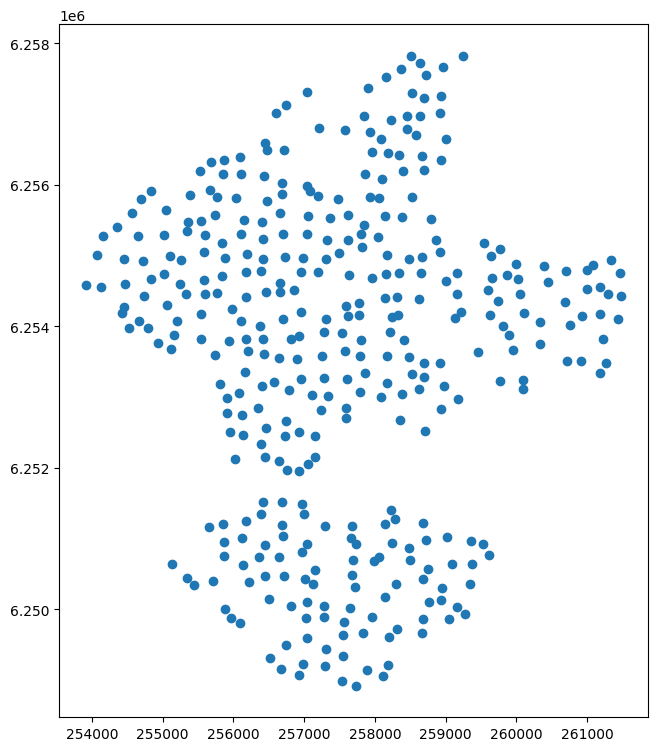

In [12]:
reduced = cg.reduce_quadtree(horo_ok,depth=5,mode="simplification") #Using the reduce_quadtree function on a gdf contianing our points

reduced.plot(figsize=(9,9))

**2.2.3/** Adding a fake attribute to our datas

Let's say we add an attribute containing the number of places in the parking area. Calling it "nb_places"

In [13]:
# Adding a fake value to parking meters points (let's say the number of places in the parking area)
horo_value = horo.copy()
with progressbar.ProgressBar(max_value=len(horo_value),widgets=widgets) as bar:
    for i in range(len(horo_value)):
        horo_value.loc[i,'nb_places'] = random.randint(1, 100) 
        bar.update(i)
#create a field based on index for merging df later
horo_value['index'] = horo_value.index
print("Sample of our data containing the 'nb_places' attribute : ")
horo_value[['nb_places','index','numhoro']].head(2)

100% 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩                                                  


Sample of our data containing the 'nb_places' attribute : 


nb_places  index   numhoro
0       22.0      0  60430102
1       95.0      1  74620201

**2.2.4/** Using reduce_quadtree algorithm with an attribute value ("selection mode")

The “selection” mode selects the point with the highest value in the chosen column, weighted by the point's depth.

In [14]:
# reduce_quadtree algorithm (selection mode)
horo_value_clp = gp.clip(horo_value, admin.loc[13:16])

def qtree_attr(figure_size, depth, display_sizes):
    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

    with progressbar.ProgressBar(max_value=5,widgets=widgets) as bar:
        horo_red = cg.reduce_quadtree(horo_value_clp,depth=depth,mode="selection",column='nb_places')
        bar.update(1)

        axs[0].set_title('Before', pad=10, family='sans-serif')
        axs[0].scatter(x=np.asarray(horo_ok.geometry.get_coordinates())[:,:1], y= np.asarray(horo_ok.geometry.get_coordinates())[:,-1])
        bar.update(2)
        ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
        bar.update(3)
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        axs[0].set_aspect('equal')

        axs[1].set_title('After', pad=10, family='sans-serif')
        
        if display_sizes == True:
            axs[1].scatter(np.asarray(horo_red.geometry.get_coordinates())[:,:1], y= np.asarray(horo_red.geometry.get_coordinates())[:,-1], s= horo_red['nb_places'])
        else:   
            axs[1].scatter(np.asarray(horo_red.geometry.get_coordinates())[:,:1], y= np.asarray(horo_red.geometry.get_coordinates())[:,-1]) 
        bar.update(4)
        ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
        bar.update(5)
        fig.axes[1].get_xaxis().set_visible(False)
        fig.axes[1].get_yaxis().set_visible(False)
        axs[1].set_xlim(left=253668, right=261883)
        axs[1].set_ylim(bottom=6248519, top=6258324)
        axs[1].set_aspect('equal')

ipywidgets.interact(qtree_attr, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                                depth = ipywidgets.IntSlider(value =5, min = 0, max = 8,step = 1,continuous_update=False),
                                display_sizes = False
                                )

interactive(children=(IntSlider(value=16, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.qtree_attr(figure_size, depth, display_sizes)>

In this case, for each group of points in which the algorithm removes points, the point with the highest value is retained. However, the reduce_quadtree algorithm also tends to even out the spatial distribution. Note that this selection mode also exists in the reduce_kmeans algorithm.

**2.2.4'/** Code details on reduce_quadtree algorithm with selection mode 

<Axes: >

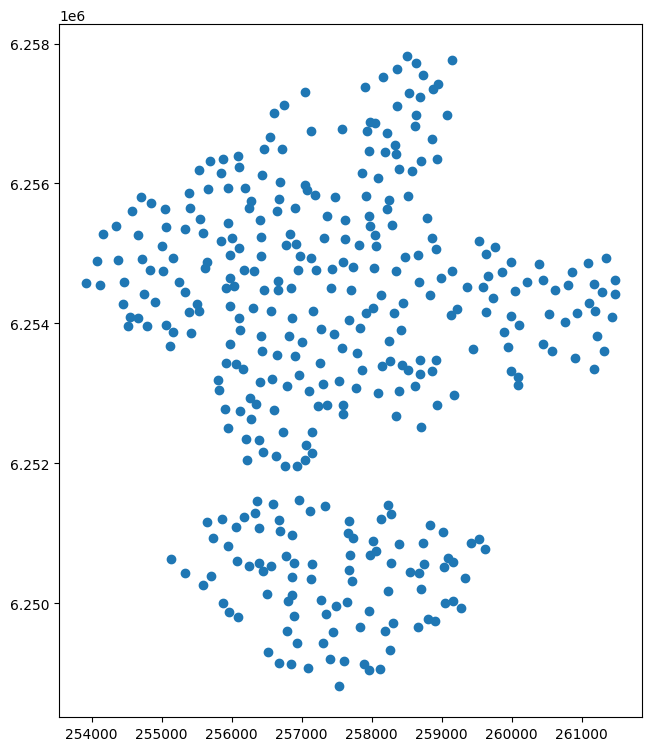

In [15]:
reduced = cg.reduce_quadtree(horo_value_clp,depth=5,mode="selection",column='nb_places')

reduced.plot(figsize=(9,9))

**2.2.5/** Using reduce_labelgrid algorithm with selection mode 

In [16]:
# Using the LabelGrid algorithm with selection mode 
horo_value_clp = gp.clip(horo_value, admin.loc[13:16])
horo_value_clp.reset_index(inplace=True)
extent = horo_value_clp.total_bounds

def lb_selec(figure_size, shape, width, height, sizes, show_grid):
    with progressbar.ProgressBar(max_value=5,widgets=widgets) as bar:
        lg = cg.reduce_labelgrid(horo_value_clp, width = width, height = height, column="nb_places", shape=shape, mode='selection', grid=True)
        bar.update(1)

        fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

        axs[0].set_title('Before', pad=10, family='sans-serif')
        if sizes == True:
            axs[0].scatter(x=np.asarray(horo_value_clp.geometry.get_coordinates())[:,:1], y= np.asarray(horo_value_clp.geometry.get_coordinates())[:,-1],s= horo_value_clp.nb_places)
        else:
            axs[0].scatter(x=np.asarray(horo_value_clp.geometry.get_coordinates())[:,:1], y= np.asarray(horo_value_clp.geometry.get_coordinates())[:,-1])
        bar.update(2)
        ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
        bar.update(3)
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        plt.xlim(extent[0]-350, extent[2]+350)
        plt.ylim(extent[1]-350, extent[3]+350)	
        axs[0].set_aspect('equal')

        axs[1].set_title('After', pad=10, family='sans-serif')
        if show_grid == True:
            for i in range(len(lg[1])):
                poly = Path.make_compound_path(Path(np.asarray(lg[1].geometry[i].exterior.coords)[:, :2]),*[Path(np.asarray(ring.coords)[:, :2]) for ring in lg[1].geometry[i].interiors])
                axs[1].add_patch(PathPatch(poly, facecolor= 'None', edgecolor='black',linewidth = 0.15, alpha= 0.7))

        if sizes == True:
            axs[1].scatter(x=np.asarray(lg[0].geometry.get_coordinates())[:,:1], y= np.asarray(lg[0].geometry.get_coordinates())[:,-1], s=lg[0].nb_places)
        else:
            axs[1].scatter(x=np.asarray(lg[0].geometry.get_coordinates())[:,:1], y= np.asarray(lg[0].geometry.get_coordinates())[:,-1])
        bar.update(4)
        ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
        bar.update(5)
        fig.axes[1].get_xaxis().set_visible(False)
        fig.axes[1].get_yaxis().set_visible(False)
        plt.xlim(extent[0]-350, extent[2]+350)
        plt.ylim(extent[1]-350, extent[3]+350)
        axs[1].set_aspect('equal')

ipywidgets.interact(lb_selec, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                              shape = ipywidgets.Dropdown(options=['square', 'diamond', 'hexagonal'], value='square', description='Cell shape:'),
                              width = ipywidgets.IntSlider(value =250, min = 0, max = 1000,step = 1,continuous_update=False),
                              height = ipywidgets.IntSlider(value =250, min = 0, max = 1000,step = 1,continuous_update=False),
                              sizes = False,
                              show_grid = False)

interactive(children=(IntSlider(value=16, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.lb_selec(figure_size, shape, width, height, sizes, show_grid)>

The Label Grid algorithm does essentially the same thing, but seems to preserve the spatial distribution of points to a greater extent, since the reduction force is the same everywhere (regardless of point density).

**2.2.5'/** Code details on reduce_points_labelgrid algorithm with selection mode 

<Axes: >

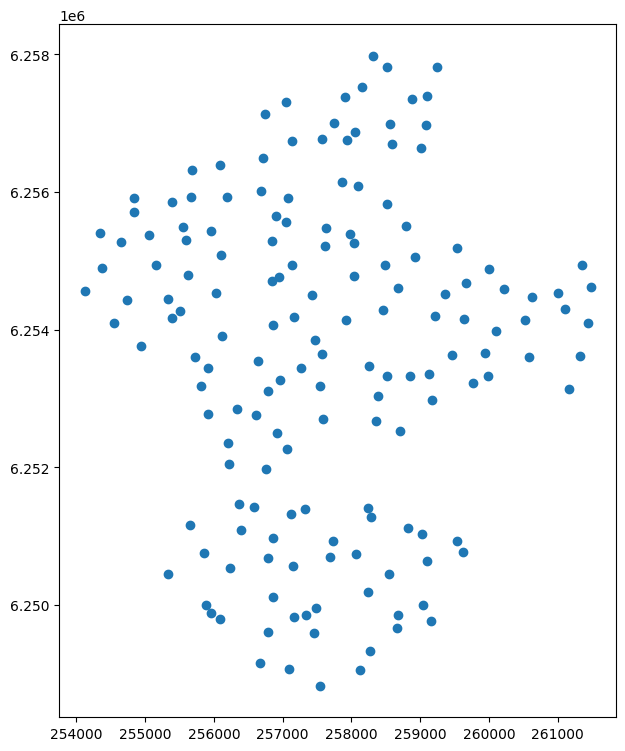

In [17]:
reduced = cg.reduce_labelgrid(horo_value_clp, width = 500, height = 500,
                                              shape="square", 
                                              column="nb_places", mode='selection')

reduced.plot(figsize=(9,9))

### **2.3/** Aggregation techniques
At some point, it becomes pointless to display point data as dots on the map. Indeed, at smaller scales (the scale of Brittany in our first example, and the scale of Paris in the second), there is either too much information to display, or too much overlap between points. In cartography, there are several ways of solving this problem. Aggregation is one of them.

Aggregation involves “merging” information from points into larger spatial entities (usually a polygon). A common type of aggregation is performed with administrative (or statistical) units. Aggregating into administrative units does not require CartAGen (only [Geopandas](https://geopandas.org/en/stable/) is used here).

**2.3.1/** Perform aggregation in administrative/statistical units

In [18]:
# Agregating points into adminstrative units in Paris
def multipolygon_to_polygon(geom): # function that transform MultiPolygon geometry to Polygon
    if isinstance(geom, MultiPolygon):
        return geom.geoms[0]
    return geom
mun = admin.copy()
mun.loc[:,'geometry'] = mun.loc[:,'geometry'].apply(multipolygon_to_polygon)
neigh = gp.read_file('data/puntos/quartier_paris.geojson')
neigh.to_crs(crs="EPSG:3857",inplace=True)
iris = gp.read_file('data/puntos/iris.geojson')
iris.to_crs(crs="EPSG:3857",inplace=True)
iris.loc[:,'geometry'] = iris.loc[:,'geometry'].apply(multipolygon_to_polygon) 

horo_enr = gp.sjoin(horo_value, mun)
horo_enr = horo_enr[["numhoro","nb_places","ID","NOM","geometry"]]
horo_enr = gp.sjoin(horo_enr, neigh)
horo_enr = horo_enr[["numhoro","nb_places","ID","NOM","n_sq_qu", "l_qu","geometry"]]
horo_enr = gp.sjoin(horo_enr, iris)
horo_enr = horo_enr[["numhoro","nb_places","ID","NOM","n_sq_qu", "l_qu","code_iris","nom_iris", "geometry"]]
horo_enr['nb_pm'] = 1

def agr_admin(figure_size, unit, value, show_units):
    if unit == 'IRIS':
        unit = 'code_iris'
    elif unit == 'neighborhoods':
        unit = 'n_sq_qu'
    else:
        unit = 'ID'

    if value == 'sum of places':
        value = 'nb_places'
    else:
        value = 'nb_pm'

    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))
    with progressbar.ProgressBar(max_value=6,widgets=widgets) as bar:
        horo_agr = horo_enr.groupby([unit]).sum(['nb_pm'])
        bar.update(1)
        if unit == 'code_iris':
            unit_to_disp = iris.merge(right=horo_agr, how='left', on = 'code_iris')
        elif unit == 'n_sq_qu':
            unit_to_disp = neigh.merge(right=horo_agr, how='left', on = 'n_sq_qu')
        else:
            unit_to_disp = mun.merge(right=horo_agr, how='left', on = 'ID')
        bar.update(2)
        axs[0].set_title('Before', pad=10, family='sans-serif')
        axs[0].scatter(x=np.asarray(horo.geometry.get_coordinates())[:,:1], y= np.asarray(horo.geometry.get_coordinates())[:,-1])
        bar.update(3)
        ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
        bar.update(4)
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        axs[0].set_aspect('equal')
        axs[0].set_xlim(left=249654, right=272000)
        axs[0].set_ylim(bottom=6243332, top=6258584)

        axs[1].set_title('After', pad=10, family='sans-serif')
        if value == 'nb_places':
            axs[1].scatter(np.asarray(unit_to_disp.geometry.centroid.get_coordinates())[:,:1], y= np.asarray(unit_to_disp.geometry.centroid.get_coordinates())[:,-1], s= unit_to_disp[value]*0.2)
        else:
            axs[1].scatter(np.asarray(unit_to_disp.geometry.centroid.get_coordinates())[:,:1], y= np.asarray(unit_to_disp.geometry.centroid.get_coordinates())[:,-1], s= unit_to_disp[value])
        if show_units == True:
            for i in range(len(unit_to_disp)):
                poly = Path.make_compound_path(Path(np.asarray(unit_to_disp.geometry[i].exterior.coords)[:, :2]),*[Path(np.asarray(ring.coords)[:, :2]) for ring in unit_to_disp.geometry[i].interiors])
                axs[1].add_patch(PathPatch(poly, facecolor= 'None', edgecolor='black',linewidth = 0.15))
        bar.update(5)
        ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
        bar.update(6)
        fig.axes[1].get_xaxis().set_visible(False)
        fig.axes[1].get_yaxis().set_visible(False)
        axs[1].set_aspect('equal')
        axs[1].set_xlim(left=249654, right=272000)
        axs[1].set_ylim(bottom=6243332, top=6258584)

ipywidgets.interact(agr_admin, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                               unit = ipywidgets.Dropdown(options=['IRIS', 'neighborhoods', 'municipalities'], value='neighborhoods', description='Agregation units:',style = {'description_width': 'initial'}),
                               value = ipywidgets.Dropdown(options=['sum of places', 'count of parking meters'], value='count of parking meters', description='Values represented:',style = {'description_width': 'initial'}),
                               show_units = False)

interactive(children=(IntSlider(value=16, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.agr_admin(figure_size, unit, value, show_units)>

In this way, you can represent aggregated data in polygonal units in the form of circles. You can also represent these units directly and define their color according to the information they contain (instead of indicating it by the size of the circle). However, this requires the calculation of ratio indicators, as it is not recommended to display stock values with colors.

**2.3.2/** Display aggregated datas in choroplete map style

In [19]:
# Creating ratio indicators to display agregated data in choroplete map style
mun.to_crs(crs="EPSG:2154",inplace=True)
mun['area'] = mun['geometry'].area/1000000 #square kilometers

neigh.to_crs(crs="EPSG:2154",inplace=True)
neigh['area'] = neigh['geometry'].area/1000000

iris.to_crs(crs="EPSG:2154",inplace=True)
iris['area'] = iris['geometry'].area/1000000

def agr_admin_choro(figure_size, unit, value, colors):
    fig = plt.figure(1, (figure_size, figure_size))

    if value == 'sum of places':
        value = 'nb_places'
    else:
        value = 'nb_pm'

    if unit == 'IRIS':
        unit = 'code_iris'
    elif unit == 'neighborhoods':
        unit = 'n_sq_qu'
    else:
        unit = 'ID'

    
    horo_agr = horo_enr.groupby([unit]).sum(['nb_pm'])
        
    if unit == 'code_iris':
        unit_to_disp = iris.merge(right=horo_agr, how='left', on = 'code_iris')
    elif unit == 'n_sq_qu':
        unit_to_disp = neigh.merge(right=horo_agr, how='left', on = 'n_sq_qu')
    else:
        unit_to_disp = mun.merge(right=horo_agr, how='left', on = 'ID')
    with progressbar.ProgressBar(max_value=len(unit_to_disp)*2,widgets=widgets) as bar:    
        for i in range(len(unit_to_disp)):
            unit_to_disp.loc[i,'density'] = unit_to_disp.loc[i,value]/unit_to_disp.loc[i,'area']
            bar.update(i)
        unit_to_disp = unit_to_disp.dropna()
        unit_to_disp = unit_to_disp.reset_index(drop = True)
        unit_to_disp.loc[:,'geometry'] = unit_to_disp.loc[:,'geometry'].apply(multipolygon_to_polygon) 
        unit_to_disp.to_crs(crs="EPSG:3857", inplace=True)

        sub1 = fig.add_subplot(121)
        sub1.set_title('Before', pad=10, family='sans-serif')
        sub1.scatter(x=np.asarray(horo.geometry.get_coordinates())[:,:1], y= np.asarray(horo.geometry.get_coordinates())[:,-1])
        ctx.add_basemap(sub1,source=ctx.providers.CartoDB.Positron)
        sub1.axes.get_xaxis().set_visible(False)
        sub1.axes.get_yaxis().set_visible(False)
        sub1.set_aspect('equal')
        sub1.set_xlim(left=249654, right=272000)
        sub1.set_ylim(bottom=6243332, top=6258584)

        sub2 = fig.add_subplot(122)
        sub2.set_title('After', pad=10, family='sans-serif')
        cmap = plt.get_cmap(colors)
        norm = mcolors.Normalize(vmin=unit_to_disp['density'].min(), vmax=unit_to_disp['density'].max())

        for j in range(len(unit_to_disp)):
            color_value = unit_to_disp.loc[j, 'density']/unit_to_disp.loc[:, 'density'].max()
            color = cmap(color_value)

            poly = Path.make_compound_path(Path(np.asarray(unit_to_disp.geometry[j].exterior.coords)[:, :2]),*[Path(np.asarray(ring.coords)[:, :2]) for ring in unit_to_disp.geometry[j].interiors])
            sub2.add_patch(PathPatch(poly, facecolor= color, edgecolor='black',linewidth = 0.15, alpha = 0.7))
            bar.update(i+j)
        mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
        mappable.set_array(unit_to_disp['density'])
        cbar = fig.colorbar(mappable, ax = sub2, fraction=0.03, pad=-0.025, orientation='vertical')
        cbar.set_label(f'{value} per km²')  

        sub2.axes.get_xaxis().set_visible(False)
        sub2.axes.get_yaxis().set_visible(False)
        sub2.set_aspect('equal') 
        sub2.set_xlim(left=249654, right=272000)
        sub2.set_ylim(bottom=6243332, top=6258584)
        ctx.add_basemap(sub2,source=ctx.providers.CartoDB.Positron)

ipywidgets.interact(agr_admin_choro, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 16,step = 1,continuous_update=False),
                               unit = ipywidgets.Dropdown(options=['IRIS', 'neighborhoods', 'municipalities'], value='neighborhoods', description='Agregation units:',style = {'description_width': 'initial'}),
                               value = ipywidgets.Dropdown(options=['sum of places', 'count of parking meters'], value='count of parking meters', description='Values represented:', style = {'description_width': 'initial'}),
                               colors = ipywidgets.Dropdown(options=['Reds', 'YlOrRd','viridis'], value='Reds', description='Color palette:', style = {'description_width': 'initial'}))

interactive(children=(IntSlider(value=16, continuous_update=False, description='figure_size', max=16, min=1), …

<function __main__.agr_admin_choro(figure_size, unit, value, colors)>

We can identify two main problems with this technique:
- There are not always administrative/statistical units available for the area being mapped.
- There are sometimes large differences in size between units, making the spatial distribution of data more difficult to read (which can be partially solved by creating ratio indicators).

For those reasons, it can be interesting to aggregate our points into regular geographical entities, such as the cells of a grid 

**2.3.3/** Using reduce_point_labelgrid (agregation mode) to perform aggregation in a grid

In [20]:
# Using the Label Grid algorithm to aggregate datas 
horo_value.to_crs(crs='EPSG:3857',inplace=True)
extent = horo_value.total_bounds

def agr_grid(figure_size, width, height, shape, value,show_grid):
    with progressbar.ProgressBar(max_value=5,widgets=widgets) as bar:
        lg = cg.reduce_labelgrid(horo_value, width = width, height = height, column="nb_places", shape=shape, mode='aggregation',grid=True)
        bar.update(1)
        fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

        axs[0].set_title('Before', pad=10, family='sans-serif')
        axs[0].scatter(x=np.asarray(horo_value.geometry.get_coordinates())[:,:1], y= np.asarray(horo_value.geometry.get_coordinates())[:,-1])
        bar.update(2)
        ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
        bar.update(3)
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        plt.xlim(extent[0]-350, extent[2]+350)
        plt.ylim(extent[1]-350, extent[3]+350)	
        axs[0].set_aspect('equal')

        axs[1].set_title('After', pad=10, family='sans-serif')
        if show_grid == True:
            for i in range(len(lg[1])):
                poly = Path.make_compound_path(Path(np.asarray(lg[1].geometry[i].exterior.coords)[:, :2]),*[Path(np.asarray(ring.coords)[:, :2]) for ring in lg[1].geometry[i].interiors])
                axs[1].add_patch(PathPatch(poly, facecolor= 'None', edgecolor='black',linewidth = 0.15, alpha= 0.7))
            
        if value == 'count of parking meters':
            axs[1].scatter(x=np.asarray(lg[0].geometry.get_coordinates())[:,:1], y= np.asarray(lg[0].geometry.get_coordinates())[:,-1], s=lg[0]['count']*2.5)
        else:
            axs[1].scatter(x=np.asarray(lg[0].geometry.get_coordinates())[:,:1], y= np.asarray(lg[0].geometry.get_coordinates())[:,-1], s=lg[0]['sum']*0.15)
        bar.update(4)
        ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
        bar.update(5)
        fig.axes[1].get_xaxis().set_visible(False)
        fig.axes[1].get_yaxis().set_visible(False)
        plt.xlim(extent[0]-350, extent[2]+350)
        plt.ylim(extent[1]-350, extent[3]+350)
        axs[1].set_aspect('equal')

ipywidgets.interact(agr_grid, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 20,step = 1,continuous_update=False),
                              shape = ipywidgets.Dropdown(options=['square', 'diamond', 'hexagonal'], value='square', description='Cell shape:'),
                              width = ipywidgets.IntSlider(value =500, min = 0, max = 1000,step = 1,continuous_update=False),
                              height = ipywidgets.IntSlider(value =500, min = 0, max = 1000,step = 1,continuous_update=False),
                              value = ipywidgets.Dropdown(options=['sum of places', 'count of parking meters'], value='count of parking meters', description='Values represented:', style = {'description_width': 'initial'}),
                              show_grid =False)

interactive(children=(IntSlider(value=16, continuous_update=False, description='figure_size', max=20, min=1), …

<function __main__.agr_grid(figure_size, width, height, shape, value, show_grid)>

As with administrative units, you can display data in the form of colored grid cells. Each cell has the same size, so data can be displayed without having to calculate a ratio indicator.

**2.3.3'/** Code details on reduce_labelgrid (aggregation mode) algorithm

<Axes: >

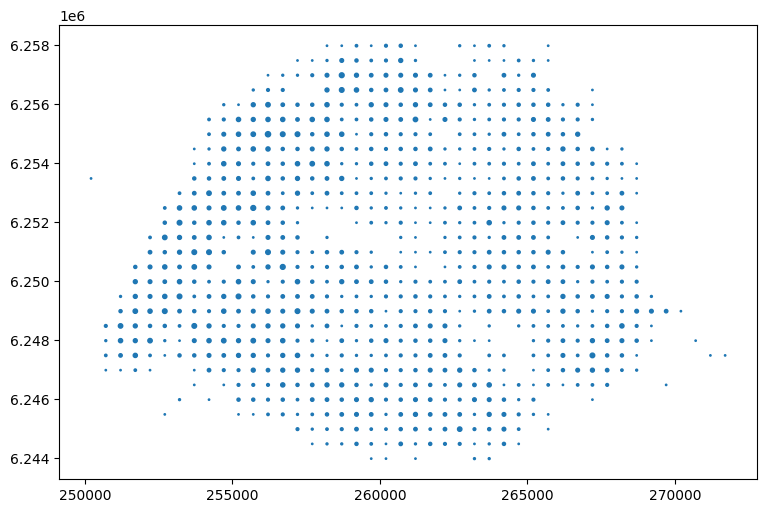

In [21]:
lg = cg.reduce_labelgrid(horo_value, width = 500, height = 500,
                                     column="nb_places", 
                                     shape="square", mode='aggregation')

lg.plot(figsize=(9,9), markersize = "count")

**2.3.4/** Display the aggregation grid from reduce_labelgrid

In [22]:
# Display the grid from Label Grid agregation 
horo_value.to_crs(crs='EPSG:3857',inplace=True)
extent = horo_value.total_bounds

def agr_grid_choro(figure_size, width, height, shape, value, colors):
    lg = cg.reduce_labelgrid(horo_value, width = width, height = height, shape=shape, mode="aggregation", column = "nb_places", grid=True)
    
    fig, axs = plt.subplots(1, 2, figsize = (figure_size,figure_size))

    axs[0].set_title('Before', pad=10, family='sans-serif')
    axs[0].scatter(x=np.asarray(horo_value.geometry.get_coordinates())[:,:1], y= np.asarray(horo_value.geometry.get_coordinates())[:,-1],s=2)
    ctx.add_basemap(axs[0],source=ctx.providers.CartoDB.Positron)
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.xlim(extent[0]-350, extent[2]+350)
    plt.ylim(extent[1]-350, extent[3]+350)
    axs[0].set_aspect('equal')
    if value == 'count of parking meters':
        value = 'count'
    else:
        value = 'sum'

    axs[1].set_title('After', pad=10, family='sans-serif')
    cmap = plt.get_cmap(colors)
    norm = mcolors.Normalize(vmin=lg[1][value].min(), vmax=lg[1][value].max())
    with progressbar.ProgressBar(max_value=len(lg[1]),widgets=widgets) as bar:
        for i in range(len(lg[1])):
            color_value = lg[1].loc[i, value]/lg[1].loc[:, value].max()
            color = cmap(color_value)
            
            poly = Path.make_compound_path(Path(np.asarray(lg[1].geometry[i].exterior.coords)[:, :2]),*[Path(np.asarray(ring.coords)[:, :2]) for ring in lg[1].geometry[i].interiors])
            if color != (0,0,0,0):
                axs[1].add_patch(PathPatch(poly, facecolor= color, edgecolor='black',linewidth = 0.15, alpha= 0.7))
            bar.update(i)
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(lg[1][value])
    cbar = fig.colorbar(mappable, ax = axs[1], fraction=0.03, pad=-0.025, orientation='vertical')
    cbar.set_label(f'{value}')

    ctx.add_basemap(axs[1],source=ctx.providers.CartoDB.Positron)
    fig.axes[1].get_xaxis().set_visible(False)
    fig.axes[1].get_yaxis().set_visible(False)
    plt.xlim(extent[0]-350, extent[2]+350)
    plt.ylim(extent[1]-350, extent[3]+350)
    axs[1].set_aspect('equal')

ipywidgets.interact(agr_grid_choro, figure_size = ipywidgets.IntSlider(value =16, min = 1, max = 20,step = 1,continuous_update=False),
                              shape = ipywidgets.Dropdown(options=['square', 'diamond', 'hexagonal'], value='square', description='Cell shape:'),
                              width = ipywidgets.IntSlider(value =500, min = 0, max = 1000,step = 1,continuous_update=False),
                              height = ipywidgets.IntSlider(value =500, min = 0, max = 1000,step = 1,continuous_update=False),
                              colors = ipywidgets.Dropdown(options=['Reds', 'YlOrRd','viridis'], value='Reds', description='Color palette:', style = {'description_width': 'initial'}),
                              value = ipywidgets.Dropdown(options=['sum of places', 'count of parking meters'], value='count of parking meters', description='Values represented:', style = {'description_width': 'initial'}))

interactive(children=(IntSlider(value=16, continuous_update=False, description='figure_size', max=20, min=1), …

<function __main__.agr_grid_choro(figure_size, width, height, shape, value, colors)>

**2.3.4'/** Code details of reduce_labelgrid to display aggregation grid

<Axes: >

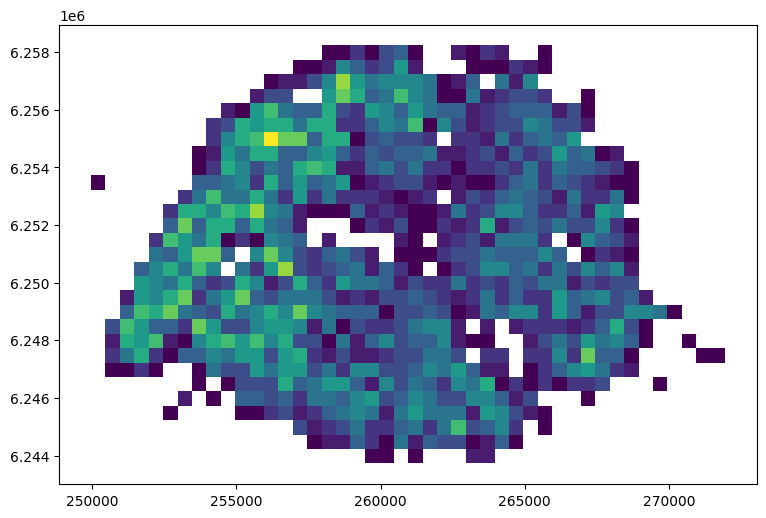

In [23]:
lg = cg.reduce_labelgrid(horo_value, width = 500, height = 500, shape="square", mode="aggregation", 
                                     column = "nb_places",
                                     grid=True)
    
lg[1].plot(figsize=(9,9),column="count")

Aggregations are good techniques for a high level of generalization, which is useful when the aim of the map is to give an overall idea of the spatial distribution of a set of point data.

However, it is often difficult to determine the level of aggregation that best suits the map: units/cells that are too large mask local variations in data distribution, while units/cells that are too small give too much detail on the map.

To overcome this problem and avoid having to choose an aggregation level, the heat map technique can be used.  

### **2.4/** The heat map


The heat map (or spatial smoothing) is a technique that involves estimating the density of point data at any point in the mapped area. Let's take a look at Kernel Density Estimation (KDE), the most common technique for constructing a heat map:

**2.4.1/** Using the heatmap algorithm from CartAGen

In [24]:
admin.to_crs(crs='EPSG:2154', inplace=True)
horo_value.to_crs(crs='EPSG:2154',inplace=True)

def heatm(cell_size, radius, activate_weighting, colors, figure_size, method, clip):    
    with progressbar.ProgressBar(max_value=3,widgets=widgets) as bar:
        if activate_weighting == True and clip==True:
            hm = cg.heatmap(horo_value, cell_size=cell_size, radius=radius, column="nb_places",clip=admin,method=method)
        elif activate_weighting == True and clip==False:
            hm = cg.heatmap(horo_value, cell_size=cell_size, radius=radius, column="nb_places", method=method)
        elif activate_weighting == False and clip==True:
            hm = cg.heatmap(horo_value, cell_size=cell_size, radius=radius, clip = admin, method=method)
        else:
            hm = cg.heatmap(horo_value, cell_size=cell_size, radius=radius, method=method)
        bar.update(1)
        ax = hm.plot(column="density",cmap=colors,alpha=0.85,figsize=(figure_size,figure_size))
        bar.update(2)
        ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,crs='EPSG:2154')
        bar.update(3)

ipywidgets.interact(heatm, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 20,step = 1,continuous_update=False),
                           cell_size = ipywidgets.IntSlider(value =250, min = 0, max = 1000, step = 1,continuous_update=False),
                           radius = ipywidgets.IntSlider(value =1000, min = 0, max = 3000, step = 1,continuous_update=False),
                           activate_weighting = False,
                           clip = False,
                           method = ipywidgets.Dropdown(options=['quartic'], value='quartic', description='Smoothing method:', style = {'description_width': 'initial'}),
                           colors = ipywidgets.Dropdown(options=['Reds', 'YlOrRd','viridis'], value='Reds', description='Color palette:', style = {'description_width': 'initial'}))

interactive(children=(IntSlider(value=250, continuous_update=False, description='cell_size', max=1000), IntSli…

<function __main__.heatm(cell_size, radius, activate_weighting, colors, figure_size, method, clip)>

**2.4.1'/** Code details on the heatmap algorithm 

<Axes: >

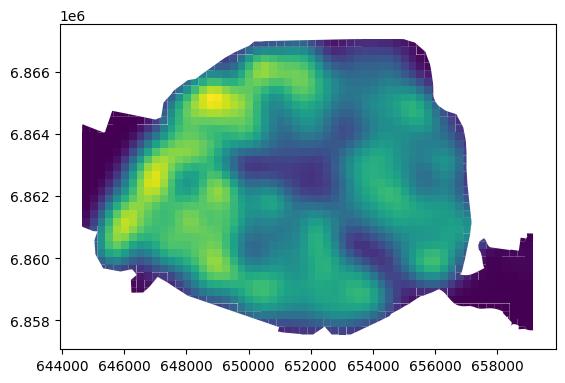

In [25]:
#make sure the input layer are in the same projected crs
horo_value.to_crs(crs='EPSG:2154',inplace=True)
admin.to_crs(crs='EPSG:2154', inplace=True)

hm = cg.heatmap(horo_value, cell_size= 250,radius= 1000, method="quartic", column="nb_places",clip=admin)
hm.plot(column="density") #the output is a gdf that you can display using the .plot() method

### **2.5/** What about Brittany ? Where is the highest density of creperies ?

If we return to our first problem, we understand that we need strong generalization processes to be able to read the spatial distribution of points, given that there is a lot of overlap. Let's try aggregation into administrative units

**2.5.1/** Aggregating points into communes of Brittany

In [26]:
def multipolygon_to_polygon(geom): # function that transform MultiPolygon geometry to Polygon
    if isinstance(geom, MultiPolygon):
        return geom.geoms[0]
    return geom

com_brittany = gp.read_file('data/puntos/com_britt.geojson')
com_brittany.loc[:,'geometry'] = com_brittany.loc[:,'geometry'].apply(multipolygon_to_polygon) 

crepes_enr = gp.sjoin(crepes, com_brittany)
crepes_enr = crepes_enr[["NOM_M","ID","POPULATION","full_id","geometry"]]

crepes_agr = crepes_enr.groupby(["ID"]).count()
crepes_com = com_brittany.merge(right=crepes_agr, how='left', on = 'ID')
crepes_com = crepes_com[["NOM_M_x","POPULATION_y","geometry_x"]]
crepes_com.set_geometry("geometry_x", inplace=True, crs="EPSG:2154")

def plt_aggr(figure_size,symbology):
    with progressbar.ProgressBar(max_value=len(crepes_com),widgets=widgets) as bar:
        if symbology == "circle":
            for i in range(len(crepes_com)):
                if crepes_com.loc[i,'POPULATION_y'] != crepes_com.loc[i,'POPULATION_y']:
                    crepes_com.loc[i,'POPULATION_y'] = 0
                crepes_com.loc[i,'nb_rest_ok'] = crepes_com.loc[i,'POPULATION_y']*15 
                bar.update(i)
            crepes_cir = crepes_com.copy() 
            crepes_cir.geometry = crepes_cir.geometry.centroid 
            ax=com_brittany.plot(figsize=(figure_size,figure_size),facecolor='None',edgecolor="lightgrey",linewidth=0.5)
            crepes_cir.plot(ax=ax,markersize ="nb_rest_ok", legend=True,color='b', alpha=0.6)
            for size in [1, 3, 25]:  
                plt.scatter([], [], s=size*15, label=str(size), color='b', alpha=0.6)

            plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='nb of restaurants')

            cities = crepes_cir[(crepes_com['nb_rest_ok'] > 225)]
            for idx, row in cities.iterrows():
                ax.text(row.geometry_x.x, row.geometry_x.y, row['NOM_M_x'], fontsize=8, ha='center')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
        else:
            crepes_com['density'] = (crepes_com['nb_rest_ok']/15)/(crepes_com.geometry.area/1000000)
            for i in range(len(crepes_com)):
                if crepes_com.loc[i,'density'] != crepes_com.loc[i,'density']:
                    crepes_com.loc[i,'density'] = 0
                sleep(0.001)
                bar.update(i)
            ax= crepes_com.plot(column ="density", cmap='YlOrRd',scheme='NaturalBreaks', legend_kwds={"title":"Restaurant per km2 \n (natural breaks)"},legend=True,figsize=(figure_size,figure_size))
            com_brittany.plot(ax=ax,facecolor='None',edgecolor="lightgrey",linewidth=0.5)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
ipywidgets.interact(plt_aggr, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 20,step = 1,continuous_update=False),
                              symbology = ipywidgets.Dropdown(options=['circle','choroplete'], value='circle', description='Symbology:', style = {'description_width': 'initial'}))


interactive(children=(IntSlider(value=12, continuous_update=False, description='figure_size', max=20, min=1), …

<function __main__.plt_aggr(figure_size, symbology)>

The proportional circles on the map clearly show which cities have the most creperies. Quimper, Rennes and Saint-Malo are the top three.
The choropleth map gives a different view of this distribution, since the number of restaurants is weighted by the surface area of the commune. In this case, it is more difficult to read the spatial distribution with this method, as very small towns have high densities.

Let's create an heatmap with those data, to get rid of the impact of the administrative boundaries in our cartographic representation.

**2.5.1/** Use the heatmap technique

In [28]:
com_brittany.to_crs(crs='EPSG:2154', inplace=True)
crepes.to_crs(crs='EPSG:2154',inplace=True)

def heatm_brit(cell_size, radius, colors, figure_size, method, clip):    
    with progressbar.ProgressBar(max_value=4,widgets=widgets) as bar:
        bar.update(1)
        if clip==True:
            hm = cg.heatmap(crepes, cell_size=cell_size, radius=radius,clip=com_brittany,method=method)
        else:
            hm = cg.heatmap(crepes, cell_size=cell_size, radius=radius, method=method)
   
        bar.update(2)
        ax = hm.plot(column="density",cmap=colors,alpha=0.85,figsize=(figure_size,figure_size))
        bar.update(3)
        ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,crs='EPSG:2154')
        bar.update(4)

ipywidgets.interact(heatm_brit, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 20,step = 1,continuous_update=False),
                           cell_size = ipywidgets.IntSlider(value =2500, min = 0, max = 10000, step = 1,continuous_update=False),
                           radius = ipywidgets.IntSlider(value =15000, min = 0, max = 30000, step = 1,continuous_update=False),
                           clip = True,
                           method = ipywidgets.Dropdown(options=['quartic'], value='quartic', description='Smoothing method:', style = {'description_width': 'initial'}),
                           colors = ipywidgets.Dropdown(options=['Reds', 'YlOrRd','viridis'], value='Reds', description='Color palette:', style = {'description_width': 'initial'}))

interactive(children=(IntSlider(value=2500, continuous_update=False, description='cell_size', max=10000), IntS…

<function __main__.heatm_brit(cell_size, radius, colors, figure_size, method, clip)>

In this case, the heat map can be used to highlight areas with a high density of restaurants, independently of administrative units. For example, although Rennes and Quimper have a similar number of creperies, the Rennes and surrounding area has a much higher density than Quimper and surrounding area.

However, the problem with the heat map technique is that the quality of the representation also depends on the number of input points. In this case, there are large empty spaces due to the lack of points (especially when the radius parameter is small), which is not ideal.

## 📍**Part 3 :** Creating cluster map with CartAGen

Cluster maps are a new way to represent point datasets, especially large ones. They consist of an interactive map in which points are merged into clusters. As you zoom out of the map, the clusters become fewer and more points are grouped together.

More and more tools allow you to create these maps. This is the case for some webmapping tools like Leaflet or Mapbox. Here is an example of what a map of parking meter clusters in Paris could look like with Leaflet

![Alt text](https://raw.githubusercontent.com/gowestmen/images/refs/heads/main/cluster_map.gif)

This interactive map is interesting because it allows you to navigate between different zoom levels without encountering the problem of overlapping points. However, the sizes of the circles are not proportional, and you can't really configure how the clusters are calculated.

Using CartAGen and other libraries can be a solution to fully control the process of creating a cluster map. Let's try it!

### **3.1/** Point aggregation into clusters

The first step to create our cluster map is to regroup our points into clusters. To perform that, we will use the [Scikit learn](https://scikit-learn.org/stable/api/sklearn.cluster.html#module-sklearn.cluster) Python library, which contains a lot of clustering algorithm. 

**3.1.1/** Creating clusters using DBSCAN algorithm

In [29]:
horo.to_crs(crs='EPSG:2154',inplace=True) #make sure the point dataset is in projected coordinate 
coords = np.vstack((horo.geometry.x, horo.geometry.y)).T #retrieve coordinates and put them in an array object

def clstr(eps, min_samples, figure_size):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples) #instanciate dbscan class, specifiying parameters
    # i.e eps = max distance for points to be consider in the same cluster
    #  min_samples = minimum number of close points to form a cluster
    clusters = dbscan.fit_predict(coords) #compute the clusters
    horo['cluster'] = clusters #add the id of the cluster of each point as a new column

    list_col_clus = []
    with progressbar.ProgressBar(max_value=len(horo.cluster.unique()),widgets=widgets) as bar:
        for i in range(len(horo.cluster.unique())):
            list_col_clus.append((np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)))
            bar.update(i)
        col_clus = matcol.LinearSegmentedColormap.from_list('col_clus',list_col_clus)

        if len(horo.cluster.unique()) > 1:
            horo.plot(column="cluster", cmap=col_clus, figsize=(figure_size,figure_size)) #plot result
        else:
            horo.plot(color="grey", figsize=(figure_size,figure_size))

ipywidgets.interact(clstr, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 16,step = 1,continuous_update=False),
                             eps = ipywidgets.IntSlider(value =500, min = 1, max = 2000,step = 1,continuous_update=False),
                             min_samples = ipywidgets.IntSlider(value =5, min = 1, max = 200,step = 1,continuous_update=False))

interactive(children=(IntSlider(value=500, continuous_update=False, description='eps', max=2000, min=1), IntSl…

<function __main__.clstr(eps, min_samples, figure_size)>

DBSCAN has the advantage of not assigning each point to a cluster. Points that are too isolated are thus considered as non-clustered. However, it is difficult to find clusters of equal sizes in our case. Let's try another clustering algorithm.

**3.1.2/** Creating clusters using HDBSCAN algorithm

In [30]:
horo_copy = horo.copy()
horo_copy.to_crs(crs='EPSG:2154',inplace=True) #make sure the point dataset is in projected coordinate 
coords = np.vstack((horo.geometry.x, horo.geometry.y)).T #retrieve coordinates and put them in an array object

def clstr_2(min_cluster_size, figure_size):
    hdb = cluster.HDBSCAN(min_cluster_size=min_cluster_size) #instanciate dbscan class, specifiying parameters
    # i.e eps = max distance for points to be consider in the same cluster
    #  min_samples = minimum number of close points to form a cluster
    clusters = hdb.fit_predict(coords) #compute the clusters
    horo_copy['cluster'] = clusters #add the id of the cluster of each point as a new column

    list_col_clus = []
    with progressbar.ProgressBar(max_value=len(horo_copy.cluster.unique()),widgets=widgets) as bar:
        for i in range(len(horo_copy.cluster.unique())):
            list_col_clus.append((np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)))
            bar.update(i)
        col_clus = matcol.LinearSegmentedColormap.from_list('col_clus',list_col_clus)

        if len(horo_copy.cluster.unique()) > 1:
            horo_copy.plot(column="cluster", cmap=col_clus, figsize=(figure_size,figure_size)) #plot result
        else:
            horo_copy.plot(color="grey", figsize=(figure_size,figure_size))

ipywidgets.interact(clstr_2, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 16,step = 1,continuous_update=False),
                           min_cluster_size = ipywidgets.IntSlider(value =5, min = 2, max = 200,step = 1,continuous_update=False))

interactive(children=(IntSlider(value=5, continuous_update=False, description='min_cluster_size', max=200, min…

<function __main__.clstr_2(min_cluster_size, figure_size)>

The HDBSCAN algorithm is designed to detect clusters of different densities, something that the DBSCAN algorithm struggles to do.

However, these two algorithms do not give satisfactory results because the point data sets here do not present large differences in density (the location of the parking meters is regular in space).

Let's use another clustering algorithm, based on distance and not density.

**3.1.3/** Creating clusters using K-means algorithm

In [31]:
horo_ok = gp.read_file("horo_ok.geojson")
coords = np.vstack((horo_ok.geometry.x, horo_ok.geometry.y)).T #retrieve coordinates and put them in an array object

def clstr_3(n_clusters, figure_size):
    with progressbar.ProgressBar(max_value=n_clusters,widgets=widgets) as bar:
        kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42) #instanciate dbscan class, specifiying parameters
        # i.e n_clusters = the number of clusters to find in the dataset 
        # random_state = used to have always the same choices regarding the initial centroïds
        clusters = kmeans.fit_predict(coords) #compute the clusters
        horo_ok['cluster'] = clusters #add the id of the cluster of each point as a new column

        list_col_clus = []
        for i in range(len(horo_ok.cluster.unique())):
            list_col_clus.append((np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)))
            bar.update(i)
        col_clus = matcol.LinearSegmentedColormap.from_list('col_clus',list_col_clus)

        if len(horo_ok.cluster.unique()) > 1:
            horo_ok.plot(column="cluster", cmap=col_clus, figsize=(figure_size,figure_size)) #plot result
        else:
            horo_ok.plot(color="grey", figsize=(figure_size,figure_size))
    
ipywidgets.interact(clstr_3, figure_size = ipywidgets.IntSlider(value =12, min = 1, max = 16,step = 1,continuous_update=False),
                           n_clusters = ipywidgets.IntSlider(value =5, min = 1, max = 20,step = 1,continuous_update=False))

interactive(children=(IntSlider(value=5, continuous_update=False, description='n_clusters', max=20, min=1), In…

<function __main__.clstr_3(n_clusters, figure_size)>

The K-means algorithm is easier to configure, because you can choose the number of clusters you want. This algorithm groups all points into clusters, even those that seem isolated. Here we have removed the parking meters that are really far from the rest of the points.

### **3.2/** Compute the hulls of the clusters

Now that we have calculated our clusters, we need to determine the spatial hull of each cluster, which will be used in the final map representation, and for calculating the number of points per cluster.

**3.2.1/** Separate the GeoDataFrame containing the points

In [32]:
#separating dataset in x clusters
list_clusters = []
with progressbar.ProgressBar(max_value=len(horo_ok.cluster.unique()),widgets=widgets) as bar:
    for i in range(len(horo_ok.cluster.unique())):
        list_clusters.append(horo_ok[(horo_ok.cluster == i)])
        bar.update(i)

if len(list_clusters) > 1:
    print("successful separation")
    print("nb of clusters : "+str(len(list_clusters)))

100% 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩                                                  


successful separation
nb of clusters : 5


We now have a list of x GeoDataFrame (depending on the number of clusters). Let's use CartAGen to compute the hull of each of these clusters.

**3.2.2/** Using CartAGen to compute the hulls

In [33]:
#compute clusters covering
unclusters = gp.read_file("unclusterd.geojson")

def hull(length, figure_size):
    global hulls
    list_hulls = []
    with progressbar.ProgressBar(max_value=len(list_clusters),widgets=widgets) as bar:
        c = 0
        for i in list_clusters:
            c += 1
            list_hulls.append(cg.hull_delaunay(list(i.geometry),length=length))
            bar.update(c)
        hulls = gp.GeoDataFrame(geometry=gp.GeoSeries(list_hulls))  
        ax = hulls.plot(cmap='Reds',figsize=(figure_size, figure_size))
        unclusters.plot(ax=ax)

ipywidgets.interact(hull, figure_size = ipywidgets.IntSlider(value =10, min = 1, max = 16,step = 1,continuous_update=False),
                           length = ipywidgets.IntSlider(value =2000, min = 1, max = 3000,step = 1,continuous_update=False))

interactive(children=(IntSlider(value=2000, continuous_update=False, description='length', max=3000, min=1), I…

<function __main__.hull(length, figure_size)>

**3.2.2'/** Details on CartAGen's hull_delaunay algorithm

<Axes: >

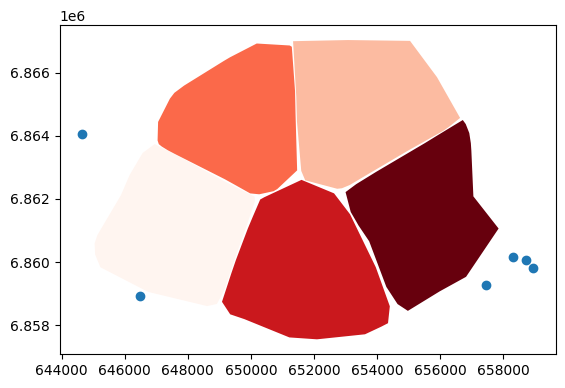

In [34]:
list_hulls_demo = []
for i in list_clusters:
    list_hulls_demo.append(cg.hull_delaunay(list(i.geometry),length=2000))
            
hulls_demo = gp.GeoDataFrame(geometry=gp.GeoSeries(list_hulls_demo))  
        
ax = hulls_demo.plot(cmap='Reds')
unclusters.plot(ax=ax)

**3.2.3/** Calculate the number of points per hull

In [35]:
hulls = hulls.set_crs(crs='EPSG:2154') #specify the crs of the hulls
horo['nb'] = 1 #creates a column for count of points

#creating id for each hull
with progressbar.ProgressBar(max_value=len(hulls),widgets=widgets) as bar:
    for i in range(len(hulls)):
        hulls.loc[i,"id_hull_1"] = i
        bar.update(i)
horo_id_hull = gp.sjoin(horo, hulls) #transfer the id of hull in each overlaping points
horo_hull_agr = horo_id_hull.groupby(['id_hull_1']).sum(['nb']) #get the sum of points for each hull id
hulls_count = hulls.merge(right=horo_hull_agr, how='left', on = 'id_hull_1') #merge this sum into the hull GeoDataFrame
hulls_count = hulls_count[['geometry','id_hull_1','nb']]
hulls_count

100% 🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩                                                  


geometry  id_hull_1   nb
0  POLYGON ((650128.635 6861919.159, 649855.429 6...        0.0  941
1  POLYGON ((653679.452 6862762.37, 653138.414 68...        1.0  592
2  POLYGON ((649146.36 6866376.079, 649342.187 68...        2.0  753
3  POLYGON ((650427.77 6862053.144, 651606.09 686...        3.0  730
4  POLYGON ((653968.657 6862853.917, 654501.136 6...        4.0  623

**3.2.4/** Display the cluster map for low level of zoom

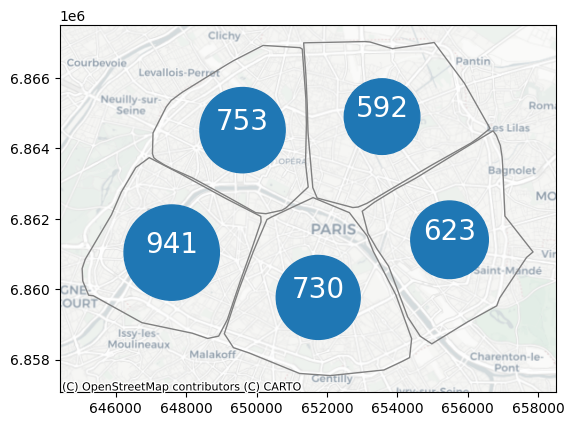

In [36]:
#Creates the map for the first zoom level

ax = hulls_count.plot(facecolor = 'None', edgecolor = "grey")
ax.scatter(x=np.asarray(hulls_count.geometry.centroid.get_coordinates())[:,:1], y= np.asarray(hulls_count.centroid.get_coordinates())[:,-1], s=hulls_count['nb']*5)
for i, label in enumerate(hulls_count['nb']):
    plt.annotate(label, (np.asarray(hulls_count.geometry.centroid.get_coordinates())[:,:1][i], np.asarray(hulls_count.centroid.get_coordinates())[:,-1][i]), 
                         ha='center',fontsize=20, color="white")

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron, crs='EPSG:2154')


With this process, we obtain a personalized map of the clusters of the parking meters of Paris. The next steps consist in calculating new clusters within each hull to obtain a less generalized layer, which will be displayed in an interactive map.

### **3.3/** Build an interactive map combining diffrent clusters

**3.3.1/** Compute new clusters within each hull

In [37]:
list_horo_lvl2 = []
list_coords_lvl2 = []
for i in range(len(horo_id_hull.id_hull_1.unique())):
    list_horo_lvl2.append(horo_id_hull[(horo_id_hull.id_hull_1 == i)])

list_coords_lvl2 = []
for i in range(len(list_horo_lvl2)):
    list_coords_lvl2.append(np.vstack((list_horo_lvl2[i].geometry.x, list_horo_lvl2[i].geometry.y)).T)
 

def clstr_4(figure_size,n_clusters):
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42) #instanciate dbscan class, specifiying parameters
    # i.e n_clusters = the number of clusters to find in the dataset 
    # random_state = used to have always the same choices regarding the initial centroïds
    clusters = kmeans.fit_predict(list_coords_lvl2[0]) #compute the clusters
    list_horo_lvl2[0].loc[:,'cluster'] = clusters #add the id of the cluster of each point as a new column

    list_col_clus_lvl2 = []
    with progressbar.ProgressBar(max_value=len(list_horo_lvl2[0].cluster.unique()),widgets=widgets) as bar:
        for i in range(len(list_horo_lvl2[0].cluster.unique())):
            list_col_clus_lvl2.append((np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)))
            bar.update(i)
        col_clus = matcol.LinearSegmentedColormap.from_list('col_clus',list_col_clus_lvl2)

        if len(list_horo_lvl2[0].cluster.unique()) > 1:
            ax = list_horo_lvl2[0].plot(column="cluster", cmap=col_clus, figsize=(figure_size,figure_size)) #plot result
        else:
            ax =list_horo_lvl2[0].plot(color="grey", figsize=(figure_size,figure_size))

ipywidgets.interact(clstr_4, figure_size = ipywidgets.IntSlider(value =8, min = 1, max = 16,step = 1,continuous_update=False),
                           n_clusters = ipywidgets.IntSlider(value =5, min = 1, max = 20,step = 1,continuous_update=False))

interactive(children=(IntSlider(value=8, continuous_update=False, description='figure_size', max=16, min=1), I…

<function __main__.clstr_4(figure_size, n_clusters)>

We can imagine choosing a different clustering algorithm for each hull, in order to be sure to make the best choice given the spatial distribution of the points. This process can be long, that is why we decide to apply the same K-means algorithm for each hull.

In [38]:
def hulls_2(length, n_clusters, figure_size):
    global hulls_count_2
    list_clusters_2 = []
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42)

    for i in range(len(list_coords_lvl2)):
        clusters = kmeans.fit_predict(list_coords_lvl2[i])
        list_horo_lvl2[i].loc[:,'cluster'] = clusters
        for j in range(n_clusters):
            list_clusters_2.append(list_horo_lvl2[i][(list_horo_lvl2[i].cluster == j)])

    list_hulls_2 = []
    with progressbar.ProgressBar(max_value=len(list_clusters_2),widgets=widgets) as bar:
        for i in list_clusters_2:
            list_hulls_2.append(cg.hull_delaunay(list(i.geometry),length=length))
            bar.update(i)
    hulls_2 = gp.GeoDataFrame(geometry=gp.GeoSeries(list_hulls_2))

    hulls_2 = hulls_2.set_crs(crs='EPSG:2154') #specify the crs of the hulls_2

    #creating id for each hull
    for i in range(len(hulls_2)):
        hulls_2.loc[i,"id_hull_2"] = i

    horo_id_hull_2 = gp.sjoin(horo, hulls_2) #transfer the id of hull in each overlaping points
    horo_hull_agr_2 = horo_id_hull_2.groupby(['id_hull_2']).sum(['nb']) #get the sum of points for each hull id
    hulls_count_2 = hulls_2.merge(right=horo_hull_agr_2, how='left', on = 'id_hull_2') #merge this sum into the hull GeoDataFrame
    hulls_count_2 = hulls_count_2[['geometry','id_hull_2','nb']]

    hulls_2.plot(cmap='Reds', figsize=(figure_size,figure_size))

ipywidgets.interact(hulls_2, figure_size = ipywidgets.IntSlider(value =8, min = 1, max = 16,step = 1,continuous_update=False),
                           n_clusters = ipywidgets.IntSlider(value =4, min = 1, max = 20,step = 1,continuous_update=False),
                           length = ipywidgets.IntSlider(value =2000, min = 1, max = 3000,step = 1,continuous_update=False))


interactive(children=(IntSlider(value=2000, continuous_update=False, description='length', max=3000, min=1), I…

<function __main__.hulls_2(length, n_clusters, figure_size)>

**3.3.2/** Combining the hulls in an interactive map

In [39]:
horo_clean = horo.loc[:,['numhoro','adresse','geometry']]
horo_clean.to_crs(crs='EPSG:4326', inplace=True)
hulls_count.to_crs(crs='EPSG:4326', inplace=True)
hulls_count_2.to_crs(crs='EPSG:4326', inplace=True)
unclusters.to_crs(crs='EPSG:4326', inplace=True)


m = ipyleaflet.Map(center=(48.8566, 2.3522), zoom=15,min_zoom =12, max_zoom = 18, basemap=ipyleaflet.basemaps.CartoDB.Positron)

def flip(x, y):
    return y, x

def create_markers_from_gdf(gdf):
    global markers
    markers = []
    for _, row in gdf.iterrows():
        lon = gdf.loc[_,'geometry'].x
        lat = gdf.loc[_,'geometry'].y

        circle_marker = ipyleaflet.CircleMarker(location=(lat, lon), radius=5, fill_opacity=0.7)
        markers.append(circle_marker)

def create_poly_from_gdf(gdf):
    global polys
    polys = []

    for _, row in gdf.iterrows():
        row['geometry'] = transform(flip, row['geometry'])
        coords = list(row['geometry'].exterior.coords) 
        polygon = ipyleaflet.Polygon(locations=coords, color="blue", fill_color="blue", fill_opacity = 0, weight=2)
        polys.append(polygon)

def create_circle_from_gdf(gdf):
    global circle_2
    circle_2 = []

    for _, row in gdf.iterrows():
        lon = gdf.loc[_,'geometry'].centroid.x
        lat = gdf.loc[_,'geometry'].centroid.y

        circle_marker = ipyleaflet.CircleMarker(location=(lat, lon), radius=int(row['nb']*0.1), fill_opacity=0.7, weight=2)
        circle_2.append(circle_marker)

create_poly_from_gdf(hulls_count)
layer_group_2 = ipyleaflet.LayerGroup(layers=polys)
create_circle_from_gdf(hulls_count)
layer_group_2_circle = ipyleaflet.LayerGroup(layers=circle_2)


create_poly_from_gdf(hulls_count_2)
layer_group_3 = ipyleaflet.LayerGroup(layers=polys)
create_circle_from_gdf(hulls_count_2)
layer_group_3_circle = ipyleaflet.LayerGroup(layers=circle_2)

create_markers_from_gdf(unclusters)
uncluster_pts = ipyleaflet.LayerGroup(layers=markers)

create_markers_from_gdf(horo_clean)
layer_group = ipyleaflet.LayerGroup(layers=markers)
m.add_layer(layer_group)

def on_zoom_change(event):
    if m.zoom < 13:
        if len(m.layers[1].layers) != len(hulls_count):
            for i in range(len(hulls_count_2)+3):
                m.remove_layer(m.layers[1])
            m.add_layer(layer_group_2_circle)
            m.add_layer(uncluster_pts)
            for i,row in hulls_count.iterrows():
                m.add(ipyleaflet.Popup(location=[row['geometry'].centroid.y,row['geometry'].centroid.x],child=ipywidgets.HTML(value = str(row['nb'])), auto_close = False, auto_pan=False))
            m.add_layer(layer_group_2)
            
                      

    elif 12 < m.zoom < 15:
        if len(m.layers[1].layers) != len(hulls_count_2):
            if len(m.layers) > 2:
                for i in range(len(hulls_count)+3):
                    m.remove_layer(m.layers[1])
            else:
                m.remove_layer(m.layers[1])
            m.add_layer(layer_group_3_circle)
            m.add_layer(uncluster_pts)
            for i,row in hulls_count_2.iterrows():
                m.add(ipyleaflet.Popup(location=[row['geometry'].centroid.y,row['geometry'].centroid.x],child=ipywidgets.HTML(value = str(row['nb'])), auto_close = False, auto_pan=False))
            m.add_layer(layer_group_3)
            
    else:
        if len(m.layers) > 2:
            for i in range(len(hulls_count_2)+3):
                m.remove_layer(m.layers[1])
       
            m.add_layer(layer_group)
    
m.observe(on_zoom_change, names='zoom')

display(m)

Map(center=[48.8566, 2.3522], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

To conclude on this example, we can say that a cluster map can be useful to represent all the parking meter data since there are many points to represent. Keep in mind that this resulting interactive map could be improved, both in terms of interactivity (being able to get information about each parking meter by clicking on it...) and symbology (improving the design of the popups indicating the number of points...).

Moreover, when it comes to representing a point dataset in an interactive map, clustering is not the only technique! In fact, all the generalization methods presented in this Notebook could be combined in a webmap. One can imagine starting with a heatmap at a low zoom level, then an aggregate representation, a reduction/displacement of points and finally a display of raw points.

Thank you for your attention !